Bank Marketing Data Set
---
Podaci se odnose na direktne marketinške kampanje (telefonski pozivi) portugalske banke. Cilj klasifikacije je da predvidi da li će se klijent pretplatiti na oročeni depozit.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Priprema i analiza podataka
---

In [2]:
dataset = pd.read_csv('bank-full.csv', sep = ';')
dataset.replace(('yes', 'no'), (1, 0), True)

benchmark = False
if not benchmark:
    dataset = dataset.drop('duration', axis = 1)
    
dataset.head(11)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,-1,0,unknown,0
5,35,management,married,tertiary,0,231,1,0,unknown,5,may,1,-1,0,unknown,0
6,28,management,single,tertiary,0,447,1,1,unknown,5,may,1,-1,0,unknown,0
7,42,entrepreneur,divorced,tertiary,1,2,1,0,unknown,5,may,1,-1,0,unknown,0
8,58,retired,married,primary,0,121,1,0,unknown,5,may,1,-1,0,unknown,0
9,43,technician,single,secondary,0,593,1,0,unknown,5,may,1,-1,0,unknown,0


In [3]:
dataset.describe()

,age,default,balance,housing,loan,day,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,63.000000,871.000000,275.000000,1.000000


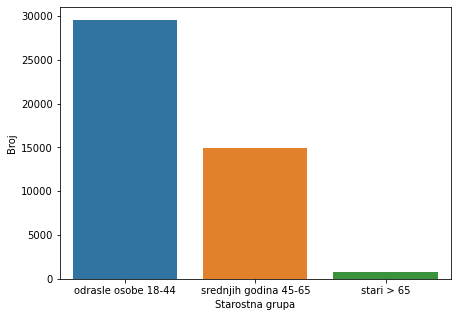

In [4]:
ages, x = np.arange(3), np.arange(3)
for age in dataset['age']:
    if age >= 18 and age <= 44:
        ages[0] += 1
    elif age >= 45 and age <= 65:
        ages[1] += 1
    elif age >= 66:
        ages[2] += 1

plt.figure(figsize = (7, 5))
sns.barplot(x, ages)
plt.xticks(x, ('odrasle osobe 18-44', 'srednjih godina 45-65', 'stari > 65'))
plt.xlabel('Starostna grupa')
plt.ylabel('Broj')
plt.show()

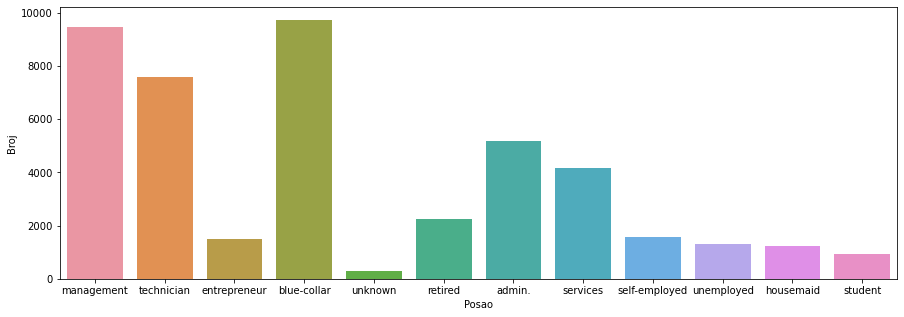

In [5]:
plt.figure(figsize = (15, 5))
sns.countplot(x = 'job', data = dataset)
plt.xlabel('Posao')
plt.ylabel('Broj')
plt.show()

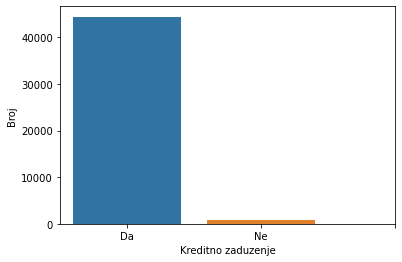

In [6]:
sns.countplot(x = 'default', data = dataset)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Kreditno zaduzenje')
plt.ylabel('Broj')
plt.show()

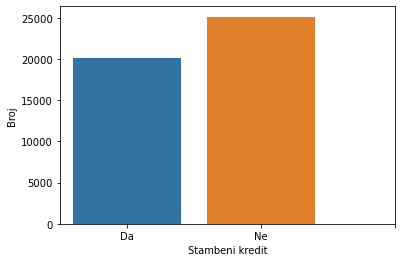

In [7]:
sns.countplot(x = 'housing', data = dataset)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Stambeni kredit')
plt.ylabel('Broj')
plt.show()

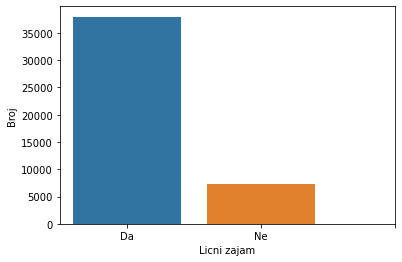

In [8]:
sns.countplot(x = 'loan', data = dataset)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Licni zajam')
plt.ylabel('Broj')
plt.show()

### Korelacije atributa
---

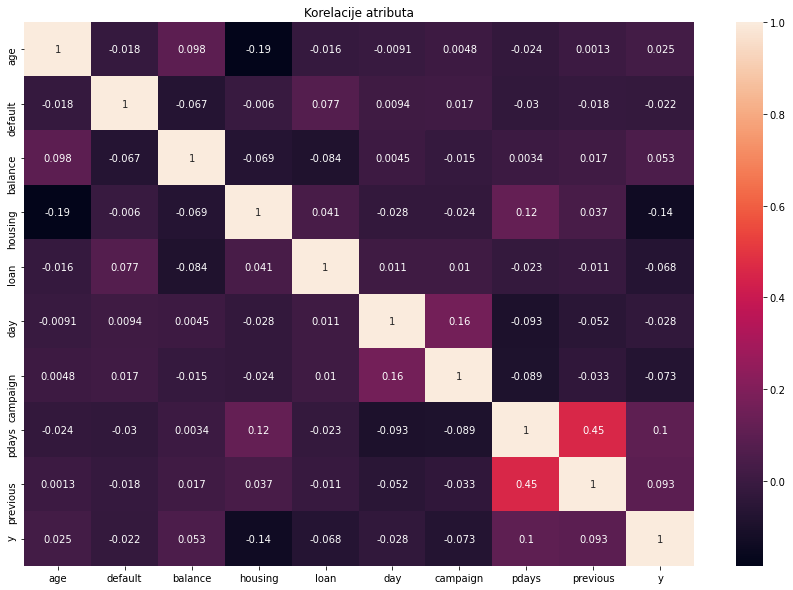

In [9]:
correlations = dataset.corr()

plt.figure(figsize = (15, 10))
sns.heatmap(correlations, annot = True)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Korelacije atributa')
plt.show()

### Priprema seta za trening i predikciju
---

In [10]:
cat_features = [[feature, .0] for feature in list(dataset.select_dtypes(object).columns)]
num_features = [[feature, .0] for feature in list(dataset.select_dtypes(exclude = object).columns)]
del num_features[-1]
first_run = True # prvi put pokrecemo skriptu kada su vaznosti num i cat features == .0

dataset_train, dataset_test = train_test_split(dataset, test_size = .1, random_state = 42)

dataset_test_original = dataset_test.copy()

dataset_train = pd.get_dummies(dataset_train, columns = dataset_train.select_dtypes(object).columns)
dataset_test = pd.get_dummies(dataset_test, columns = dataset_test.select_dtypes(object).columns)

y = pd.factorize(dataset_train['y'])[0]
dataset_train = dataset_train.drop('y', axis = 1)

dataset_test = dataset_test.drop('y', axis = 1)

### Trening
---

Text(0, 0.5, 'stopa greske')

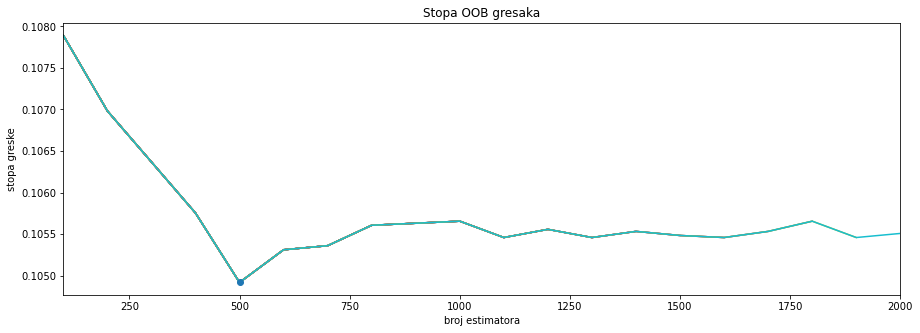

In [11]:
clf = RandomForestClassifier(warm_start = True, oob_score = True)

min_estimators = 100
max_estimators = 2000

oob_errors = []
min_oob_error = 1.0
min_oob_estimator = min_estimators

plt.figure(figsize = (15, 5))
for index in range(min_estimators, max_estimators + 1, 100):
    clf.set_params(n_estimators = index)
    clf.fit(dataset_train, y)
    
    oob_error = 1 - clf.oob_score_
    oob_errors.append((index, oob_error))
    
    if (oob_error < min_oob_error):
        min_oob_error = oob_error
        min_oob_estimator = index
        importances = clf.feature_importances_

    xoob, yoob = zip(*oob_errors)
    plt.plot(xoob, yoob)
    
plt.plot(min_oob_estimator, min_oob_error, 'o')
plt.xlim(min_estimators, max_estimators)
plt.title('Stopa OOB gresaka')
plt.xlabel('broj estimatora')
plt.ylabel('stopa greske')

### Izracunavanje vaznosti kategorijalnih i numerickih atributa
---

Text(0, 0.5, 'vaznost')

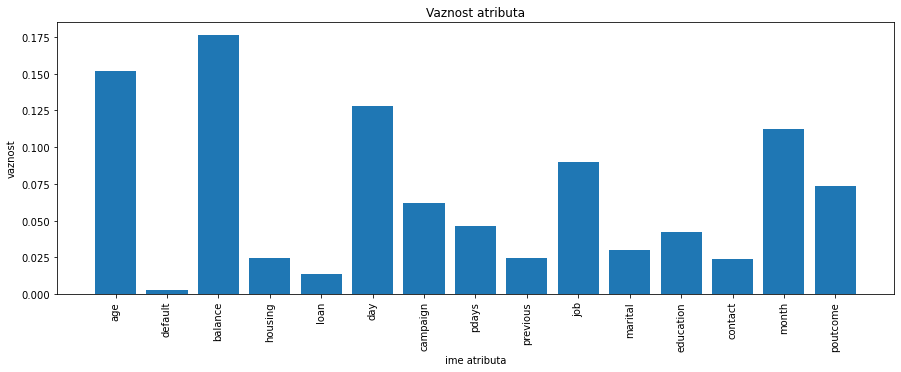

In [12]:
if first_run:
    index, cat_feature_index, num_feature_index = (0,) * 3
    last_cat_feature = cat_features[0][0]

    for feature in list(dataset_train):
        if feature.startswith(tuple(cat_feature.rsplit('_', 1)[0] for cat_feature, importance in cat_features)):
            if not feature.startswith(last_cat_feature):
                last_cat_feature = feature.rsplit('_', 1)[0]
                cat_feature_index += 1
                
            cat_features[cat_feature_index][1] += importances[index]
        else:
            num_features[num_feature_index][1] = importances[index]
            num_feature_index += 1
            
        index += 1
        
    feature_importances = num_features + cat_features
    
    first_run = False
    
plt.figure(figsize = (15, 5))
xfi, yfi = zip(*feature_importances)
plt.bar(xfi, yfi)
plt.xticks(rotation = 90)
plt.title('Vaznost atributa')
plt.xlabel('ime atributa')
plt.ylabel('vaznost')

### Predikcija
---

In [13]:
test_y = clf.predict(dataset_test)

dataset_test_original['y'] = test_y

dataset_test_original.loc[dataset_test_original['y'] == 1].head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
41828,30,management,single,tertiary,0,536,0,0,cellular,15,oct,1,105,1,success,1
24088,37,admin.,married,secondary,0,1967,0,0,telephone,27,oct,1,-1,0,unknown,1
43708,65,retired,married,unknown,0,679,0,0,cellular,13,may,2,178,1,success,1
39774,33,management,married,tertiary,0,1323,0,0,cellular,1,jun,1,-1,0,unknown,1
40429,28,management,single,tertiary,0,492,0,0,cellular,2,jul,1,-1,0,unknown,1
44583,24,student,single,secondary,0,431,0,0,cellular,19,aug,11,185,5,success,1
29183,36,management,married,tertiary,0,82,0,0,cellular,2,feb,1,178,4,success,1
44501,56,technician,divorced,secondary,0,3450,0,0,cellular,10,aug,1,181,2,success,1
43013,36,technician,married,tertiary,0,341,0,0,cellular,12,feb,2,183,1,success,1
42269,46,management,married,tertiary,0,2671,0,0,cellular,13,nov,3,91,4,success,1


### Analiza predikcije gde je y = 1 (pretplatio se na oročeni depozit)
---

In [14]:
dataset_deposited = dataset_test_original.loc[dataset_test_original['y'] == 1]

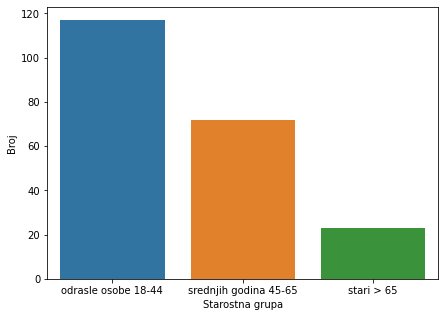

In [15]:
ages, x = np.arange(3), np.arange(3)
for age in dataset_deposited['age']:
    if age >= 18 and age <= 44:
        ages[0] += 1
    elif age >= 45 and age <= 65:
        ages[1] += 1
    elif age >= 66:
        ages[2] += 1

plt.figure(figsize = (7, 5))
sns.barplot(x, ages)
plt.xticks(x, ('odrasle osobe 18-44', 'srednjih godina 45-65', 'stari > 65'))
plt.xlabel('Starostna grupa')
plt.ylabel('Broj')
plt.show()

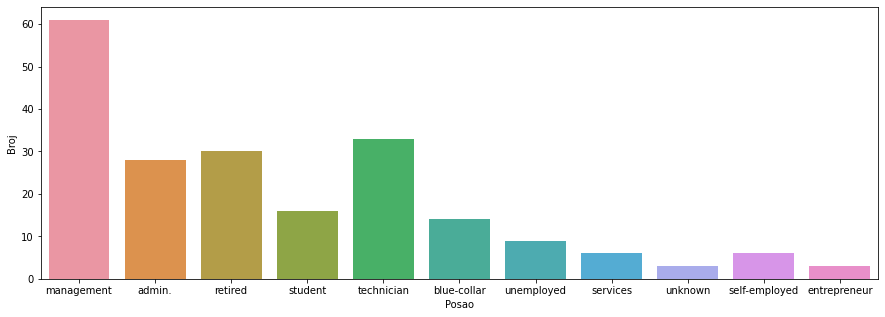

In [16]:
plt.figure(figsize = (15, 5))
sns.countplot(x = 'job', data = dataset_deposited)
plt.xlabel('Posao')
plt.ylabel('Broj')
plt.show()

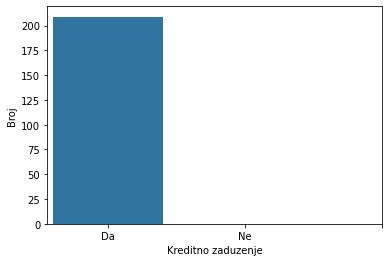

In [17]:
sns.countplot(x = 'default', data = dataset_deposited)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Kreditno zaduzenje')
plt.ylabel('Broj')
plt.show()

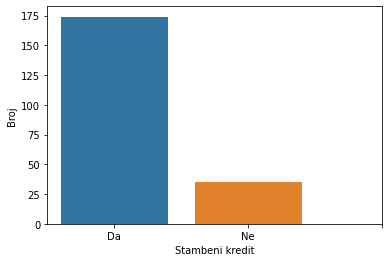

In [18]:
sns.countplot(x = 'housing', data = dataset_deposited)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Stambeni kredit')
plt.ylabel('Broj')
plt.show()

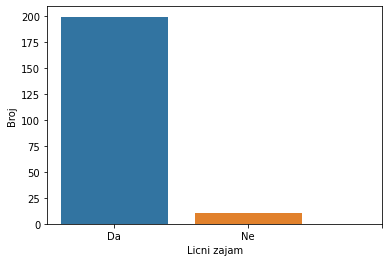

In [19]:
sns.countplot(x = 'loan', data = dataset_deposited)
plt.xticks(x, ('Da', 'Ne'))
plt.xlabel('Licni zajam')
plt.ylabel('Broj')
plt.show()